# Kalman Filter Experiments 

Please go to this [cell](#experiment) to check the experiment.

In [83]:
#reload edited modules automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
import os
os.environ['KERAS_BACKEND'] = 'plaidml.keras.backend'
from utils import create_permuted_mnist_task
from model import cnn_model

In [85]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display

In [86]:
#ignore the warning messages
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [111]:
#Plot the accuracy of test data
#Parameters:
# - name: the name of the model. It will be used in label
# - acc: list of accuracy
# - data_num: which data is plotted(D1,D2 or D3)
def acc_plot(name,acc,data_num):
    plt.figure(1)
    sub = '31'+str(data_num)
    plt.subplot(sub)
    plt.title('test accuracy on {}th dataset'.format(data_num))
    plt.plot(acc,label=name)
    plt.ylabel('acc')
    plt.xlabel('training time')
    for i in range(len(acc)-1):
        plt.vlines((i+1),0,1,color='r',linestyles='dashed')
    plt.legend(loc='upper left')
    plt.subplots_adjust(wspace=1,hspace=1)
    plt.savefig('./images/permuted.png'.format(name))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
def plot_history(history,file_name,model,shift=10):
    plt.subplot(211)
    plt.title('accuracy on current training data')
    for i in range(shift):
        plt.vlines(10*(i+1),0,1,color='r',linestyles='dashed')

    plt.plot(history.history['acc'],label='{}'.format(model))
    plt.ylabel('acc')
    plt.xlabel('training time')
    plt.legend(loc='upper right')
    plt.subplot(212)
    plt.title('validation accuracy on original data')
    plt.plot(history.history['val_acc'],label='{}'.format(model))
    plt.ylabel('acc')
    plt.xlabel('training time')
    for i in range(shift):
        plt.vlines(10*(i+1),0,1,color='r',linestyles='dashed')
    plt.legend(loc='upper right')
    plt.subplots_adjust(wspace=1,hspace=1)
    plt.savefig('./images/{}.png'.format(file_name))
    

In [88]:
#record the test accuracy
def test_acc(model,acc_test_d1,acc_test_d2,acc_test_d3):
    acc_test_d1.append(model.evaluate(task[0].test.images,task[0].test.labels))
    acc_test_d2.append(model.evaluate(task[1].test.images,task[1].test.labels))
    acc_test_d3.append(model.evaluate(task[2].test.images,task[2].test.labels))

def save_acc(name,d):
	import json
	for i in range(3):
		path = './logs/permuted/acc{}/{}.txt'.format(str(i+1),name)
		with open(path,'w') as f:
			json.dump(d[i],f)

In [89]:
def train(name):

    acc_test_d1 = []
    acc_test_d2 = []
    acc_test_d3 = []
    t1_x,t1_y = task[0].train.images,task[0].train.labels
    t2_x,t2_y = task[1].train.images,task[1].train.labels
    t3_x,t3_y = task[2].train.images,task[2].train.labels

    model = cnn_model()
    model.val_data(task[0].validation.images,task[0].validation.labels)
    model.fit(t1_x,t1_y)
    test_acc(model,acc_test_d1,acc_test_d2,acc_test_d3)
    
    if name == 'kal':
        for i in range(1,TASK_NUM):
            print('---'*10,i,'---'*10)
            model.transfer(task[i].train.images,task[i].train.labels)
            test_acc(model,acc_test_d1,acc_test_d2,acc_test_d3)
        print('go back learning')
        model.transfer(t1_x,t1_y,num=1)
        test_acc(model,acc_test_d1,acc_test_d2,acc_test_d3)
        model.transfer(t2_x,t2_y,num=2)
        test_acc(model,acc_test_d1,acc_test_d2,acc_test_d3)
        model.transfer(t3_x,t3_y,num=3)
        test_acc(model,acc_test_d1,acc_test_d2,acc_test_d3)

    if name == 'nor':
        for i in range(1,TASK_NUM):
            print('---'*10,i,'---'*10)
            model.fit(task[i].train.images,task[i].train.labels)
            test_acc(model,acc_test_d1,acc_test_d2,acc_test_d3)
        print('go back learning')
        model.fit(t1_x,t1_y)
        model.fit(t2_x,t2_y)
        model.fit(t3_x,t3_y)
        test_acc(model,acc_test_d1,acc_test_d2,acc_test_d3)

    model.save(name)
    history = model.get_history()
    
    return acc_test_d1,acc_test_d2,acc_test_d3,history,model

In [90]:
def mnist_imshow(img):
    plt.imshow(img.reshape([28,28]), cmap="gray")
    plt.axis('off')

# Experiment: <a id='experiment'></a>


Load the data.
In this experiment, I train 20 tasks sequentially.
The first dataset is the original Mnist data, the others are the permuted mnist dataset with different seed, so the images are differnet.

Assumes the datasets are D_1,D_2,D_3,D_4...D_20

After training on these datasets, I train the model on the first 3 dataset again, which are D1,D2 and D_3.

In [91]:
#Load the drift data
TASK_NUM = 20
task = create_permuted_mnist_task(TASK_NUM)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


This is the training images

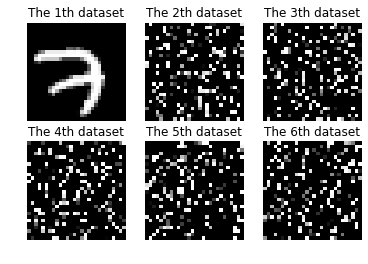

In [105]:
for i in range(6):
    plt.subplot(2,3,i+1)
    mnist_imshow(task[i].train.images[0])
    plt.title('The {}th dataset'.format(str(i+1)))

##### We train the kalman network first. 

Different from previous kalman filter, the fisher information is added into the Kalman Gain to cater the new tasks.
 $K_k = \frac{P_{k|k-1} } { (P_{k|k-1} + R * F^*) }$

The $F^*$ is the normalized Fisher Information. The reason is that the model will be strictly restricted from the previous gradients($P$)
which is relatively lower than the current gradient($R$). So I normalize the Fisher Information by using $F_i^* = \frac{F_i - \min F_i}{\max F_i - \min F_i}$

In this experiment, I use the emperical diagonal fisher information(The same as this [paper](https://arxiv.org/pdf/1612.00796.pdf)). It's calculated by squaring the gradients.

In [93]:
print('--'*10,'kal','--'*10)
kal_d1,kal_d2,kal_d3,kal_history,kal_model = train('kal')
save_acc('kal',[kal_d1,kal_d2,kal_d3])

-------------------- kal --------------------
Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 2s 45us/step - loss: 1.3362 - acc: 0.6458 - val_loss: 0.7340 - val_acc: 0.8342
Epoch 2/10
55000/55000 [==============================] - 2s 45us/step - loss: 0.6081 - acc: 0.8519 - val_loss: 0.4965 - val_acc: 0.8762
Epoch 3/10
55000/55000 [==============================] - 3s 46us/step - loss: 0.4736 - acc: 0.8768 - val_loss: 0.4166 - val_acc: 0.8922
Epoch 4/10
55000/55000 [==============================] - 2s 45us/step - loss: 0.4160 - acc: 0.8886 - val_loss: 0.3739 - val_acc: 0.9026
Epoch 5/10
55000/55000 [==============================] - 3s 46us/step - loss: 0.3825 - acc: 0.8951 - val_loss: 0.3480 - val_acc: 0.9058
Epoch 6/10
55000/55000 [==============================] - 3s 46us/step - loss: 0.3599 - acc: 0.9002 - val_loss: 0.3293 - val_acc: 0.9100
Epoch 7/10
55000/55000 [==============================] - 2s 45us/step - loss: 0.34

C:\Users\Mozzi\Desktop\kalman-master\experiment\model.py:151: RuntimeWarning: invalid value encountered in true_divide
  temp = np.absolute(pre_grad[i]) / ( np.absolute(cur_grad[i])  * self.FISHER[i] + np.absolute(pre_grad[i]) )


55000/55000 [==============================] - 11s 198us/step - loss: 1.6054 - acc: 0.4813 - val_loss: 0.2887 - val_acc: 0.9184
Epoch 2/10
55000/55000 [==============================] - 11s 196us/step - loss: 0.9589 - acc: 0.7244 - val_loss: 0.2888 - val_acc: 0.9184
Epoch 3/10
55000/55000 [==============================] - 11s 197us/step - loss: 0.7839 - acc: 0.7768 - val_loss: 0.2889 - val_acc: 0.9182
Epoch 4/10
55000/55000 [==============================] - 11s 196us/step - loss: 0.6954 - acc: 0.8029 - val_loss: 0.2890 - val_acc: 0.9184
Epoch 5/10
55000/55000 [==============================] - 11s 198us/step - loss: 0.6402 - acc: 0.8180 - val_loss: 0.2891 - val_acc: 0.9188
Epoch 6/10
55000/55000 [==============================] - 11s 202us/step - loss: 0.6018 - acc: 0.8279 - val_loss: 0.2892 - val_acc: 0.9192
Epoch 7/10
55000/55000 [==============================] - 11s 199us/step - loss: 0.5732 - acc: 0.8350 - val_loss: 0.2894 - val_acc: 0.9190
Epoch 8/10
55000/55000 [==============

10000/10000 [==============================] - 0s 27us/step
Convolutional neural network test loss: 0.3333991416454315
Convolutional neural network test accuracy: 0.9031
10000/10000 [==============================] - 0s 28us/step
Convolutional neural network test loss: 0.550109329032898
Convolutional neural network test accuracy: 0.8349
10000/10000 [==============================] - 0s 28us/step
Convolutional neural network test loss: 0.8487617190361023
Convolutional neural network test accuracy: 0.736
------------------------------ 5 ------------------------------
Train on 55000 samples, validate on 5000 samples
G is not None!!~
17.872448979591837 percent fisher information is updated
12.0 percent fisher information is updated
24.6 percent fisher information is updated
30.0 percent fisher information is updated
4 784
use previous fisher information
Epoch 1/10
55000/55000 [==============================] - 11s 199us/step - loss: 3.7131 - acc: 0.0784 - val_loss: 0.3248 - val_acc: 0.9082

55000/55000 [==============================] - 11s 196us/step - loss: 4.1218 - acc: 0.1113 - val_loss: 0.3440 - val_acc: 0.9042
Epoch 6/10
55000/55000 [==============================] - 11s 197us/step - loss: 4.1084 - acc: 0.1123 - val_loss: 0.3425 - val_acc: 0.9058
Epoch 7/10
55000/55000 [==============================] - 11s 196us/step - loss: 4.0953 - acc: 0.1135 - val_loss: 0.3412 - val_acc: 0.9056
Epoch 8/10
55000/55000 [==============================] - 11s 197us/step - loss: 4.0822 - acc: 0.1146 - val_loss: 0.3404 - val_acc: 0.9060
Epoch 9/10
55000/55000 [==============================] - 11s 196us/step - loss: 4.0693 - acc: 0.1155 - val_loss: 0.3396 - val_acc: 0.9060
Epoch 10/10
10000/10000 [==============================] - 0s 27us/step
Convolutional neural network test loss: 0.3543122308731079
Convolutional neural network test accuracy: 0.8977
10000/10000 [==============================] - 0s 28us/step
Convolutional neural network test loss: 0.6656584516525269
Convolutional n

7.237244897959184 percent fisher information is updated
12.0 percent fisher information is updated
8.0 percent fisher information is updated
0.0 percent fisher information is updated
4 784
use previous fisher information
Epoch 1/10
55000/55000 [==============================] - 11s 197us/step - loss: 3.3549 - acc: 0.1570 - val_loss: 0.3884 - val_acc: 0.8884
Epoch 2/10
55000/55000 [==============================] - 11s 198us/step - loss: 3.3441 - acc: 0.1582 - val_loss: 0.3874 - val_acc: 0.8888
Epoch 3/10
55000/55000 [==============================] - 11s 197us/step - loss: 3.3330 - acc: 0.1592 - val_loss: 0.3867 - val_acc: 0.8886
Epoch 4/10
55000/55000 [==============================] - 11s 197us/step - loss: 3.3222 - acc: 0.1601 - val_loss: 0.3863 - val_acc: 0.8884
Epoch 5/10
55000/55000 [==============================] - 11s 198us/step - loss: 3.3118 - acc: 0.1610 - val_loss: 0.3863 - val_acc: 0.8896
Epoch 6/10
55000/55000 [==============================] - 11s 197us/step - loss: 3.3

55000/55000 [==============================] - 11s 198us/step - loss: 3.8284 - acc: 0.0855 - val_loss: 0.4094 - val_acc: 0.8786
Epoch 10/10
10000/10000 [==============================] - 0s 27us/step
Convolutional neural network test loss: 0.4376781108379364
Convolutional neural network test accuracy: 0.8678
10000/10000 [==============================] - 0s 28us/step
Convolutional neural network test loss: 0.8647579146385193
Convolutional neural network test accuracy: 0.7081
10000/10000 [==============================] - 0s 28us/step
Convolutional neural network test loss: 1.0376045557022096
Convolutional neural network test accuracy: 0.6607
------------------------------ 16 ------------------------------
Train on 55000 samples, validate on 5000 samples
G is not None!!~
3.7653061224489797 percent fisher information is updated
0.0 percent fisher information is updated
0.4 percent fisher information is updated
0.0 percent fisher information is updated
4 784
use previous fisher informatio

55000/55000 [==============================] - 11s 199us/step - loss: 4.0603 - acc: 0.1093 - val_loss: 0.4262 - val_acc: 0.8744
Epoch 4/10
55000/55000 [==============================] - 11s 197us/step - loss: 4.0463 - acc: 0.1100 - val_loss: 0.4245 - val_acc: 0.8736
Epoch 5/10
55000/55000 [==============================] - 11s 198us/step - loss: 4.0324 - acc: 0.1109 - val_loss: 0.4231 - val_acc: 0.8756
Epoch 6/10
55000/55000 [==============================] - 11s 198us/step - loss: 4.0182 - acc: 0.1116 - val_loss: 0.4223 - val_acc: 0.8750
Epoch 7/10
55000/55000 [==============================] - 11s 198us/step - loss: 4.0043 - acc: 0.1125 - val_loss: 0.4221 - val_acc: 0.8760
Epoch 8/10
55000/55000 [==============================] - 11s 197us/step - loss: 3.9908 - acc: 0.1134 - val_loss: 0.4225 - val_acc: 0.8766
Epoch 9/10
55000/55000 [==============================] - 11s 199us/step - loss: 3.9777 - acc: 0.1141 - val_loss: 0.4232 - val_acc: 0.8758
Epoch 10/10
10000/10000 [=============

10000/10000 [==============================] - 0s 28us/step
Convolutional neural network test loss: 0.3936706900596619
Convolutional neural network test accuracy: 0.8878
10000/10000 [==============================] - 0s 28us/step
Convolutional neural network test loss: 0.47317353820800784
Convolutional neural network test accuracy: 0.8561


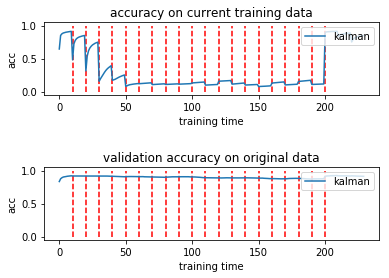

In [103]:
plot_history(kal_history,'res','kalman',shift=20)

The precise accuracy of the training data(The first figure) is: (Te last 3 is the go back training accuracy on the D1,D2 and D3 respectively).
###### The model can only learn the first 3 datasets in an acceptable rate. According to my other experiments, it cannot be fixed by simply adding layers. 

In [100]:
acc_kal = kal_history.history['acc'][::9][1:]
for acc in acc_kal:
    print(str(acc)[:5],end='  ')

0.913  0.846  0.733  0.342  0.218  0.107  0.122  0.107  0.108  0.111  0.120  0.142  0.104  0.163  0.122  0.102  0.079  0.132  0.101  0.153  0.170  0.114  0.913  0.881  0.835  

The precise accuracy of D1 (The second figure) is: (The last 3 is the go back training accuracy on the D1,D2 and D3 respectively). It shows that the model can learn the learnt dataset efficiently. 

In [96]:
print(kal_history.history['val_acc'][::9][1:])

[0.9212, 0.9184, 0.9196, 0.9172, 0.9104, 0.9102, 0.9086, 0.904, 0.9016, 0.9068, 0.9044, 0.8938, 0.889, 0.891, 0.8892, 0.8908, 0.8862, 0.8782, 0.8766, 0.8822, 0.8714, 0.8758, 0.9236, 0.9208, 0.9168]


##### Train a conventional neural networks

In [97]:
print('--' * 10, 'nor', '--' * 10)
nor_d1, nor_d2, nor_d3,nor_history,nor_model = train('nor')
save_acc('nor', [nor_d1, nor_d2, nor_d3])

-------------------- nor --------------------
Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 2s 45us/step - loss: 1.3138 - acc: 0.6551 - val_loss: 0.7375 - val_acc: 0.8242
Epoch 2/10
55000/55000 [==============================] - 2s 45us/step - loss: 0.6121 - acc: 0.8487 - val_loss: 0.5016 - val_acc: 0.8744
Epoch 3/10
55000/55000 [==============================] - 3s 46us/step - loss: 0.4765 - acc: 0.8746 - val_loss: 0.4212 - val_acc: 0.8926
Epoch 4/10
55000/55000 [==============================] - 3s 47us/step - loss: 0.4194 - acc: 0.8863 - val_loss: 0.3801 - val_acc: 0.8988
Epoch 5/10
55000/55000 [==============================] - 2s 45us/step - loss: 0.3867 - acc: 0.8935 - val_loss: 0.3531 - val_acc: 0.9040
Epoch 6/10
55000/55000 [==============================] - 2s 45us/step - loss: 0.3647 - acc: 0.8987 - val_loss: 0.3359 - val_acc: 0.9066
Epoch 7/10
55000/55000 [==============================] - 2s 45us/step - loss: 0.34

Epoch 2/10
55000/55000 [==============================] - 3s 54us/step - loss: 0.4279 - acc: 0.8770 - val_loss: 0.7420 - val_acc: 0.7804
Epoch 3/10
55000/55000 [==============================] - 3s 54us/step - loss: 0.3694 - acc: 0.8933 - val_loss: 0.7768 - val_acc: 0.7688
Epoch 4/10
55000/55000 [==============================] - 3s 55us/step - loss: 0.3384 - acc: 0.9023 - val_loss: 0.8113 - val_acc: 0.7618
Epoch 5/10
55000/55000 [==============================] - 3s 55us/step - loss: 0.3175 - acc: 0.9085 - val_loss: 0.8624 - val_acc: 0.7510
Epoch 6/10
55000/55000 [==============================] - 3s 55us/step - loss: 0.3017 - acc: 0.9134 - val_loss: 0.8982 - val_acc: 0.7408
Epoch 7/10
55000/55000 [==============================] - 3s 55us/step - loss: 0.2889 - acc: 0.9168 - val_loss: 0.9234 - val_acc: 0.7320
Epoch 8/10
55000/55000 [==============================] - 3s 55us/step - loss: 0.2782 - acc: 0.9203 - val_loss: 0.9353 - val_acc: 0.7290
Epoch 9/10
55000/55000 [=================

55000/55000 [==============================] - 3s 54us/step - loss: 0.3602 - acc: 0.8947 - val_loss: 2.3324 - val_acc: 0.4854
Epoch 4/10
55000/55000 [==============================] - 3s 54us/step - loss: 0.3289 - acc: 0.9038 - val_loss: 2.4207 - val_acc: 0.4722
Epoch 5/10
55000/55000 [==============================] - 3s 54us/step - loss: 0.3076 - acc: 0.9103 - val_loss: 2.4808 - val_acc: 0.4646
Epoch 6/10
55000/55000 [==============================] - 3s 54us/step - loss: 0.2917 - acc: 0.9151 - val_loss: 2.5024 - val_acc: 0.4628
Epoch 7/10
55000/55000 [==============================] - 3s 54us/step - loss: 0.2790 - acc: 0.9191 - val_loss: 2.5734 - val_acc: 0.4518
Epoch 8/10
55000/55000 [==============================] - 3s 54us/step - loss: 0.2683 - acc: 0.9217 - val_loss: 2.5946 - val_acc: 0.4488
Epoch 9/10
55000/55000 [==============================] - 3s 54us/step - loss: 0.2591 - acc: 0.9252 - val_loss: 2.6026 - val_acc: 0.4482
Epoch 10/10
10000/10000 [===========================

55000/55000 [==============================] - 3s 55us/step - loss: 0.3225 - acc: 0.9056 - val_loss: 2.7963 - val_acc: 0.3308
Epoch 5/10
55000/55000 [==============================] - 3s 54us/step - loss: 0.3011 - acc: 0.9126 - val_loss: 2.7596 - val_acc: 0.3330
Epoch 6/10
55000/55000 [==============================] - 3s 55us/step - loss: 0.2850 - acc: 0.9171 - val_loss: 2.8248 - val_acc: 0.3262
Epoch 7/10
55000/55000 [==============================] - 3s 54us/step - loss: 0.2724 - acc: 0.9215 - val_loss: 2.8372 - val_acc: 0.3282
Epoch 8/10
55000/55000 [==============================] - 3s 54us/step - loss: 0.2618 - acc: 0.9244 - val_loss: 2.8632 - val_acc: 0.3236
Epoch 9/10
55000/55000 [==============================] - 3s 54us/step - loss: 0.2529 - acc: 0.9271 - val_loss: 2.9113 - val_acc: 0.3240
Epoch 10/10
10000/10000 [==============================] - 0s 27us/step
Convolutional neural network test loss: 3.0275848426818848
Convolutional neural network test accuracy: 0.31
10000/100

55000/55000 [==============================] - 3s 54us/step - loss: 0.3053 - acc: 0.9122 - val_loss: 3.8254 - val_acc: 0.2988
Epoch 6/10
55000/55000 [==============================] - 3s 54us/step - loss: 0.2892 - acc: 0.9163 - val_loss: 3.9642 - val_acc: 0.2908
Epoch 7/10
55000/55000 [==============================] - 3s 54us/step - loss: 0.2763 - acc: 0.9209 - val_loss: 3.9383 - val_acc: 0.2924
Epoch 8/10
55000/55000 [==============================] - 3s 54us/step - loss: 0.2657 - acc: 0.9241 - val_loss: 3.9615 - val_acc: 0.2846
Epoch 9/10
55000/55000 [==============================] - 3s 54us/step - loss: 0.2565 - acc: 0.9268 - val_loss: 4.0065 - val_acc: 0.2852
Epoch 10/10
10000/10000 [==============================] - 0s 27us/step
Convolutional neural network test loss: 4.011006852722168
Convolutional neural network test accuracy: 0.2737
10000/10000 [==============================] - 0s 28us/step
Convolutional neural network test loss: 3.931356238555908
Convolutional neural networ

55000/55000 [==============================] - 2s 44us/step - loss: 0.2402 - acc: 0.9296 - val_loss: 0.2248 - val_acc: 0.9364
Epoch 8/10
55000/55000 [==============================] - 2s 44us/step - loss: 0.2311 - acc: 0.9327 - val_loss: 0.2169 - val_acc: 0.9392
Epoch 9/10
55000/55000 [==============================] - 2s 44us/step - loss: 0.2231 - acc: 0.9351 - val_loss: 0.2103 - val_acc: 0.9408
Epoch 10/10
55000/55000 [==============================] - 2s 44us/step - loss: 0.2162 - acc: 0.9370 - val_loss: 0.2043 - val_acc: 0.9416
Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 3s 54us/step - loss: 0.5774 - acc: 0.8214 - val_loss: 0.2696 - val_acc: 0.9244
Epoch 2/10
55000/55000 [==============================] - 3s 54us/step - loss: 0.3396 - acc: 0.8982 - val_loss: 0.2855 - val_acc: 0.9202
Epoch 3/10
55000/55000 [==============================] - 3s 54us/step - loss: 0.2967 - acc: 0.9113 - val_loss: 0.2808 - val_acc: 0.9208
Ep

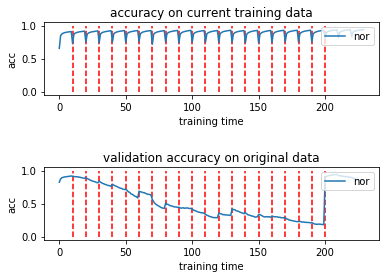

In [107]:
plot_history(nor_history,'res','nor',shift=20)

The precise accuracy of the training data(The first figure) is: (Te last 3 is the go back training accuracy on the D1,D2 and D3 respectively).

In [101]:
acc_nor = nor_history.history['acc'][::9][1:]
for acc in acc_nor:
    print(str(acc)[:5],end='  ')

0.910  0.914  0.914  0.914  0.913  0.908  0.903  0.888  0.876  0.740  0.928  0.922  0.919  0.921  0.912  0.908  0.901  0.895  0.879  0.753  0.930  0.926  0.932  0.933  0.929  

The precise accuracy of D1 (The second figure) is: (The last 3 is the go back training accuracy on the D1,D2 and D3 respectively).

In [102]:
print(nor_history.history['val_acc'][::9][1:])

[0.9188, 0.8882, 0.8304, 0.779, 0.7408, 0.6458, 0.6664, 0.5012, 0.4916, 0.4446, 0.427, 0.36, 0.2866, 0.3282, 0.3796, 0.3174, 0.309, 0.2992, 0.2672, 0.2288, 0.2084, 0.1818, 0.9392, 0.909, 0.8618]


#### The accuracy comparison between kalman and normal neural network on the D1,D2 and D3 test dataset.

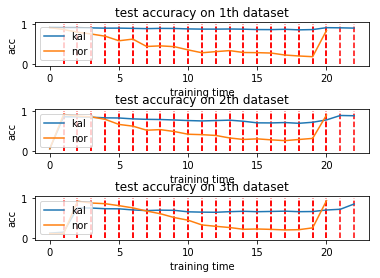

In [112]:
acc_plot('kal',kal_d1,1)
acc_plot('kal',kal_d2,2)
acc_plot('kal',kal_d3,3)
acc_plot('nor',nor_d1,1)
acc_plot('nor',nor_d2,2)
acc_plot('nor',nor_d3,3)

#### Precise accuracy

To make it clear, I calculate the $accuracy(kal) - accuracy(nor)$

In [124]:
import numpy as np
print('test accuracy differnt on D1:',(np.array(kal_d1[:21]) - np.array(nor_d1)))

accuracy diff: [0.0012 0.0469 0.1154 0.1553 0.2029 0.3198 0.2718 0.451  0.4424 0.4599
 0.5313 0.5983 0.5686 0.5469 0.5898 0.5841 0.5927 0.651  0.6611 0.6855
 0.0705]


In [126]:
import numpy as np
print('test accuracy differnt on D2:',(np.array(kal_d2[:21]) - np.array(nor_d2)))

test accuracy differnt on D2: [ 0.0022 -0.0603 -0.0209 -0.0103  0.0377  0.1631  0.1834  0.275   0.256
  0.2917  0.3463  0.3469  0.3769  0.4503  0.4605  0.4047  0.428   0.4575
  0.4093  0.4082 -0.1211]


In [127]:
import numpy as np
print('test accuracy differnt on D3:',(np.array(kal_d3[:21]) - np.array(nor_d3)))

test accuracy differnt on D3: [ 0.0109  0.0344 -0.1663 -0.1266 -0.1274 -0.0801 -0.052   0.0112  0.0914
  0.1831  0.2123  0.3241  0.3552  0.401   0.4548  0.4375  0.4534  0.4746
  0.4554  0.413  -0.2355]


Below is the precise test accuracy:

In [128]:
print('kalman model on D1:',kal_d1)
print('Conventional model on D1:',nor_d1)

kalman model on D1: [0.917, 0.9161, 0.916, 0.9104, 0.9031, 0.9043, 0.8981, 0.891, 0.8977, 0.8955, 0.8843, 0.879, 0.8786, 0.8821, 0.8774, 0.8678, 0.8664, 0.8745, 0.8606, 0.8673, 0.9158, 0.912, 0.9047]
Conventional model on D1: [0.9158, 0.8692, 0.8006, 0.7551, 0.7002, 0.5845, 0.6263, 0.44, 0.4553, 0.4356, 0.353, 0.2807, 0.31, 0.3352, 0.2876, 0.2837, 0.2737, 0.2235, 0.1995, 0.1818, 0.8453]


In [129]:
print('kalman model on D2:',kal_d2)
print('Conventional model on D2:',nor_d2)

kalman model on D2: [0.0543, 0.8611, 0.8592, 0.85, 0.8349, 0.8312, 0.8084, 0.797, 0.7926, 0.7805, 0.7662, 0.7565, 0.7662, 0.7761, 0.7487, 0.7081, 0.7063, 0.7159, 0.6966, 0.7229, 0.7828, 0.8946, 0.8878]
Conventional model on D2: [0.0521, 0.9214, 0.8801, 0.8603, 0.7972, 0.6681, 0.625, 0.522, 0.5366, 0.4888, 0.4199, 0.4096, 0.3893, 0.3258, 0.2882, 0.3034, 0.2783, 0.2584, 0.2873, 0.3147, 0.9039]


In [130]:
print('kalman model on D3:',kal_d3)
print('Conventional model on D3:',nor_d3)

kalman model on D3: [0.1187, 0.1425, 0.759, 0.7539, 0.736, 0.7335, 0.7055, 0.6886, 0.6999, 0.6954, 0.6577, 0.6497, 0.6463, 0.6614, 0.6711, 0.6607, 0.6672, 0.6744, 0.6613, 0.6649, 0.7037, 0.7225, 0.8561]
Conventional model on D3: [0.1078, 0.1081, 0.9253, 0.8805, 0.8634, 0.8136, 0.7575, 0.6774, 0.6085, 0.5123, 0.4454, 0.3256, 0.2911, 0.2604, 0.2163, 0.2232, 0.2138, 0.1998, 0.2059, 0.2519, 0.9392]
